# Gaussian Processes Regresion and its Applications

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(1234)

# Some matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Usefull imports

In [2]:
import scipy.special

from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm as norm
from scipy.stats import uniform as uniform

from numpy.linalg import inv

## Useful utility functions

These are just to visualize the results of the Gaussian Process Regression, there is no magic here.

In [3]:
def plot_gp_samples(ax, x, F, title=None, color=None, alpha=1.):
    '''
    Plot samples from a 1D Gaussian process.
    
    Args:
        ax:    Axis for plotting.
        x:     x coordinates.
        F:     Samples from a Gaussian process,
               shape: n_samples times len(x).
        title: Plot title.
    '''
    colors = ['r', 'g', 'b', 'c', 'm']
    
    if F.ndim == 1:
        F = F.reshape(1, -1)
        
    for y, c in zip(F, colors * (1 + len(F) // len(colors))):
        plot_color = color if color else c
        ax.plot(x, y, marker='', lw=2.0, color=plot_color, alpha=alpha)
    
    ax.set_xlabel(r'$x$', fontsize='xx-large')
    ax.set_ylabel(r'$f(x)$', fontsize='xx-large')
    
    if title is not None:
        ax.set_title(title)

In [4]:
def plot_gpr(ax, V, mu, Sigma, U, f_U, y, sigma, title=None):
    '''
    Plot Gaussian Process Regression results.
    
    Args:
        ax:    Axis for plotting.
        V:     Regression points.
               shape m times 1.
        mu:    Expected value of f(V),
               shape: m times 1.
        Sigma: Covariance of f(V),
               shape: m times m.
        U:     Points at which values of f were observed,
               shape: n times 1.
        f_U:   True values of f(U),
               shape: n times 1.
        y:     Noisy observations of f(U),
               shape: n times 1.
        sigma: Assumed noise level (standard deviation of y).
        title: Plot title.
    
    Note:
        Normally, f(U) is not know (observations are noisy). We use it
        only to illustrate regression results.
    '''
    ax.plot(V, mu, marker='', lw=2.0, color='r')
    
    f_V_2sigma = 2 * np.sqrt(np.diag(Sigma))
    
    V, mu = V.squeeze(), mu.squeeze()
    plt.fill_between(V, mu + f_V_2sigma, mu - f_V_2sigma, alpha=0.3)
    
    ax.scatter(U, y, s=100, c='g', marker='x', zorder=2)
    ax.errorbar(U, f_U[:, 0], sigma, None, marker="o", ls='', capsize=5)

    ax.set_xlabel(r'$x$', fontsize='xx-large')
    ax.set_ylabel(r'$f(x)$', fontsize='xx-large')
    
    if title is not None:
        ax.set_title(title)

## Covariance functions

We begin by defining several covariance functions.

In [5]:
def sqdist(X, Y):
    '''
    Calculate all-to-all squared distances between points in X and Y.
    
    Args:
        X: Point coordinates,
           shape: n times d.
        Y: Point coordinates,
           shape: m times d.
    
    Returns:
        n times m matrix with squared Euclidean distances.
    '''
    X2 = np.sum(X * X, axis=1, keepdims=True)
    Y2 = np.sum(Y * Y, axis=1, keepdims=True)
    
    return X2 + Y2.T - 2 * X @ Y.T

- White noise kernel:

    $$\large
    k\left(\mathbf{x}, \mathbf{y}\right) = \begin{cases}
                                              \sigma^2 & \textrm{if } \mathbf{x} = \mathbf{y} \\
                                              0        & \textrm{if } \mathbf{x} \neq \mathbf{y}
                                             \end{cases}$$

In [6]:
def white_noise_kernel(X, Y, sigma=1.0):
    D = np.sqrt(sqdist(X, Y))
    D = D == 0.0
    return (sigma * sigma) * D

- Gaussian kernel:

    $$\large
     k\left(\mathbf{x}, \mathbf{y}\right) =
      \exp\left(-\frac{\left\|\mathbf{x} - \mathbf{y}\right\|^2}
                      {2l^2}\right)$$

In [7]:
def gaussian_kernel(X, Y, l=1.0):
    return np.exp(-(sqdist(X, Y) / 2 * l * l))

- Periodic kernel:

    $$\large
     k\left(\mathbf{x}, \mathbf{y}\right) =
      \exp\left(
        -\frac{2}{l^2}
        \sin^2\left(
          \frac{\pi \left\|\mathbf{x} - \mathbf{y}\right\|}{p}
        \right)
      \right)$$

In [8]:
def periodic_kernel(X, Y, l=1.0, p=1.0):
    return np.exp(-1 * (2 / l**2) * np.power(np.sin(np.pi * np.sqrt(sqdist(X, Y)) / p), 2))

- Matérn kernel:

    $$\large
    k\left(\mathbf{x}, \mathbf{y}\right) =
      \frac{2^{1-\nu}}{\Gamma(\nu)}
      \left(\sqrt{2\nu}
            \frac{\left\|\mathbf{x} - \mathbf{y}\right\|}{l}
      \right)^\nu
      K_\nu\left(
        \sqrt{2\nu}
        \frac{\left\|\mathbf{x} - \mathbf{y}\right\|}{l}
      \right)$$

In [9]:
def matern_kernel(X, Y, l=1.0, nu=0.5):
    D = np.sqrt(sqdist(X, Y))
    D[D == 0.0] += np.finfo(float).eps
    
    Q = np.sqrt(2 * nu) * D / l
    
    K = Q ** nu
    K *= (2 ** (1. - nu)) / scipy.special.gamma(nu)
    K *= scipy.special.kv(nu, Q)
    
    return K

## Gaussian Processes

Now, lets sample some functions from Gaussian processes defined by these covariance functions. Formally, we calculate:

$$ \large
  \begin{aligned}
     f & \sim GP \left(\mathbf{0}, k\right) \\
     \mathbf{f_X} & = f\left(\mathbf{X}\right)
   \end{aligned}
$$

and then plot: $\left(\mathbf{X}, \mathbf{f_X}\right)$.

Implement `sample_gp` function which takes as an input:

- An array `X` of point coordinates, with shape: $n \times d$.
- A covariance function: `kernel`.
- Number of samples to draw from the Gaussian process: `n_samples`.
- Additional arguments for the covariance function: `kernel_args`.

and returns samples from the Gaussian process evaluated at `X`. The result should be a NumPy array with shape: $n\_samples \times n$.

In [10]:
def sample_gp(X, kernel=gaussian_kernel, n_samples=1, **kernel_args):
    return mvn.rvs(np.zeros(X.shape[0]), kernel(X, X, **kernel_args), n_samples)

In [11]:
def sample_gp_posterior(mu, Sigma):
    return mvn.rvs(mu, Sigma)

Lets draw samples from a 1D Gaussian process. Samples will be evaluated at `n_points` spaced equally between `xmin` and `xmax`.

In [12]:
n_points = 200
xmin, xmax = -5.0, 5.0

X = np.linspace(xmin, xmax, n_points).reshape(-1, 1)

Samples from a Gaussian process with white noise covariance.

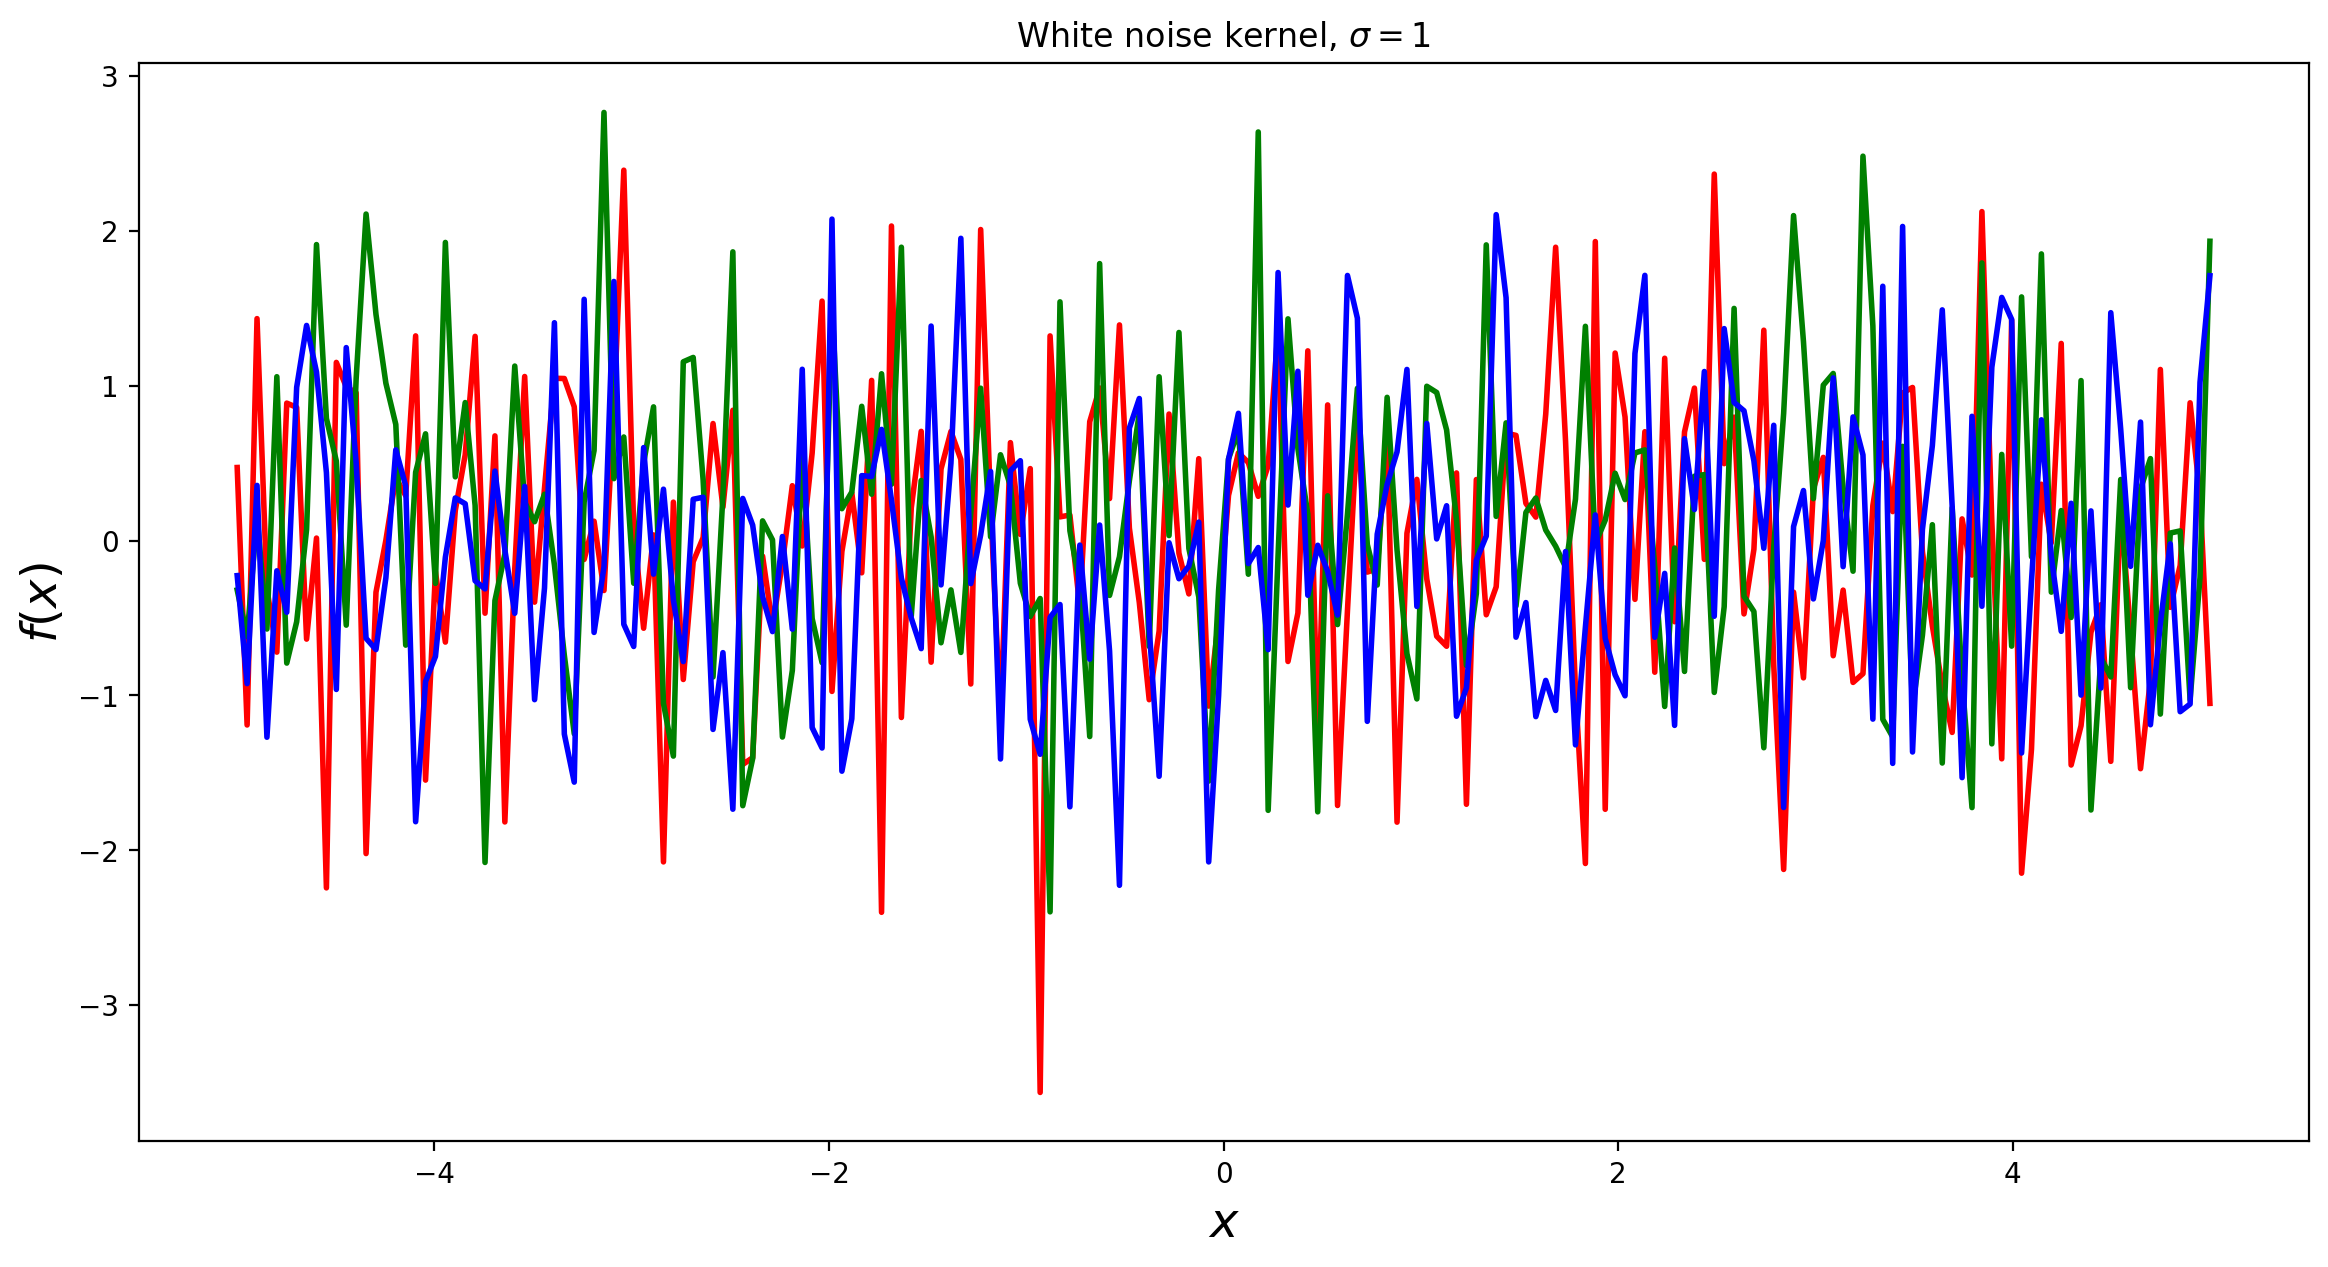

In [13]:
f = sample_gp(X, kernel=white_noise_kernel, n_samples=3, sigma=1)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'White noise kernel, $\sigma=1$')

Samples from a Gaussian process with Gaussian covariance.

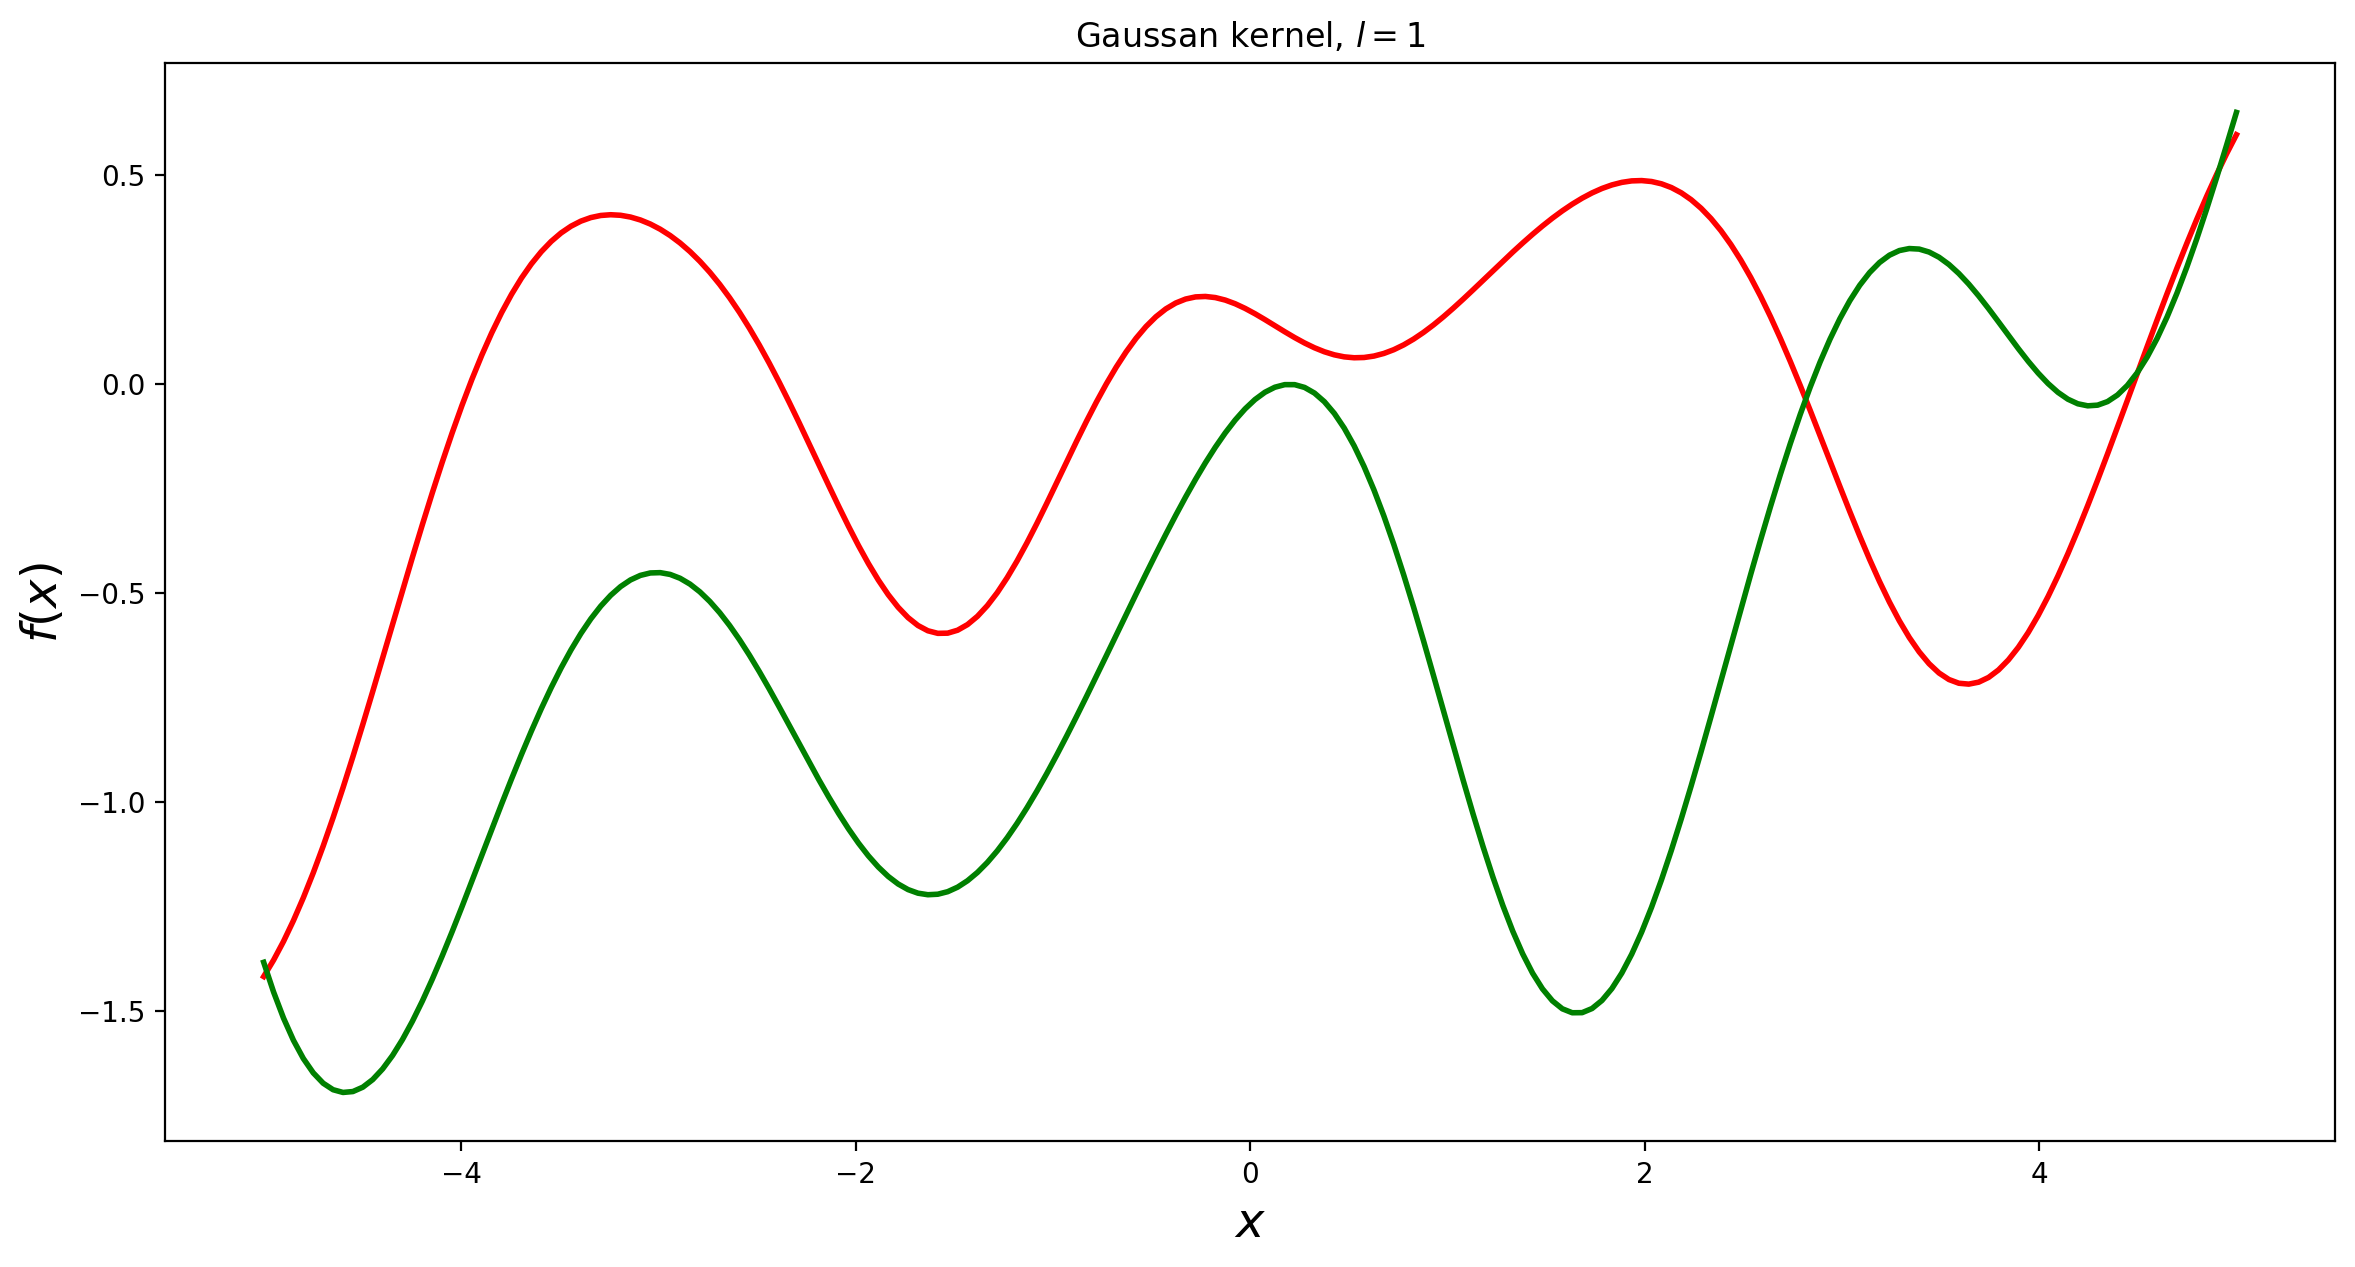

In [14]:
f = sample_gp(X, kernel=gaussian_kernel, n_samples=2, l=1)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Gaussan kernel, $l=1$')

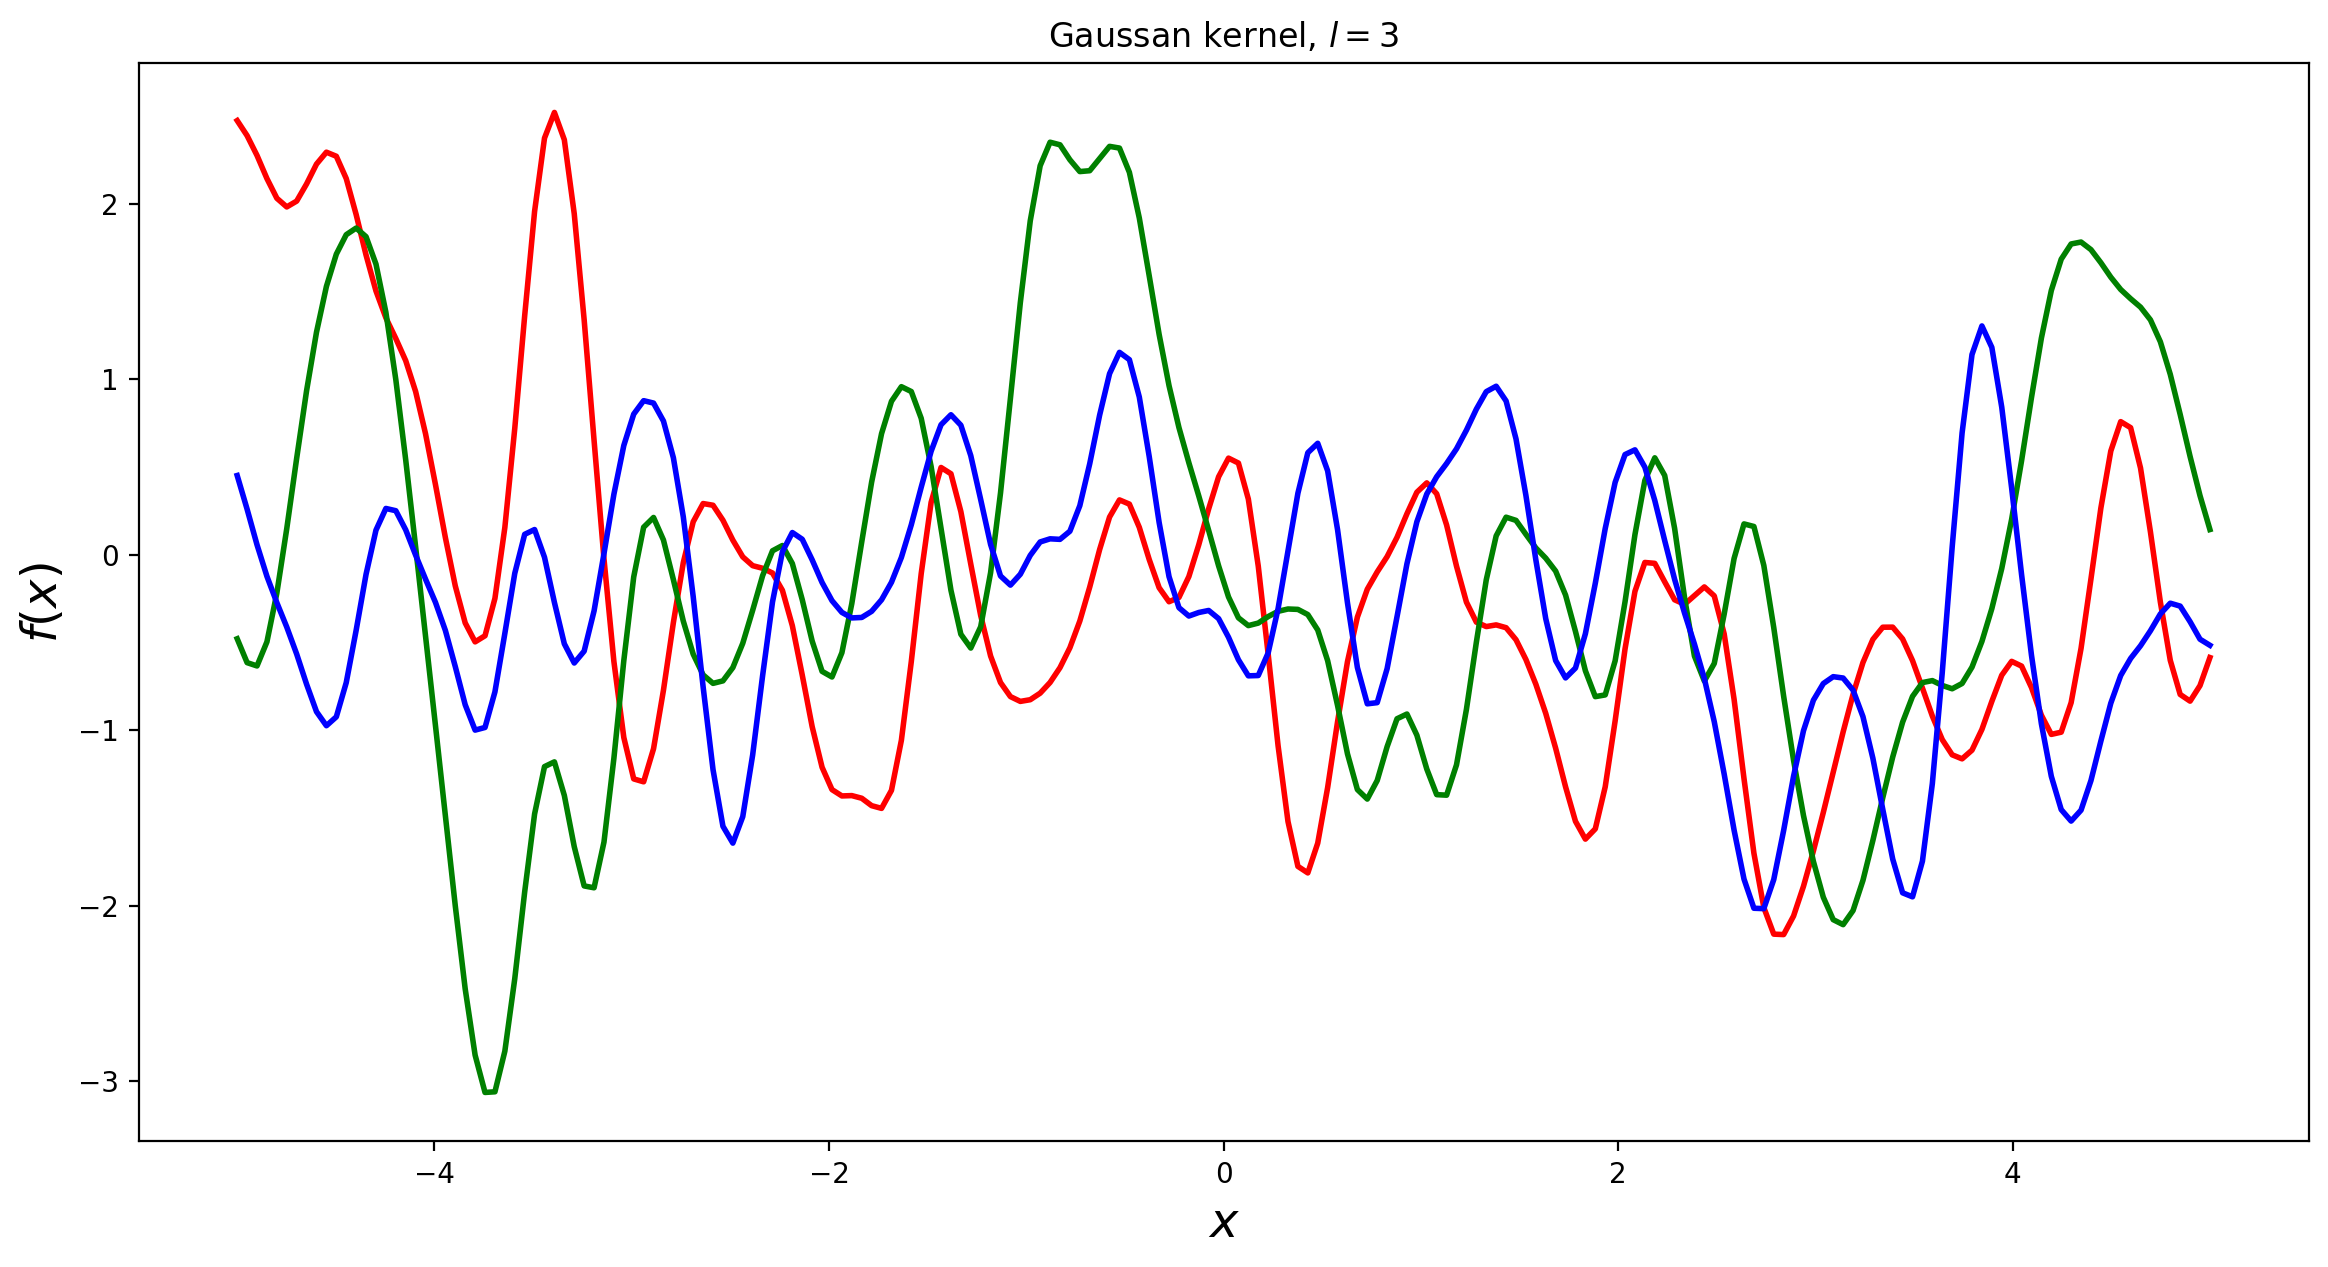

In [15]:
f = sample_gp(X, kernel=gaussian_kernel, n_samples=3, l=5)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Gaussan kernel, $l=3$')

Samples from a Gaussian process with periodic covariance.

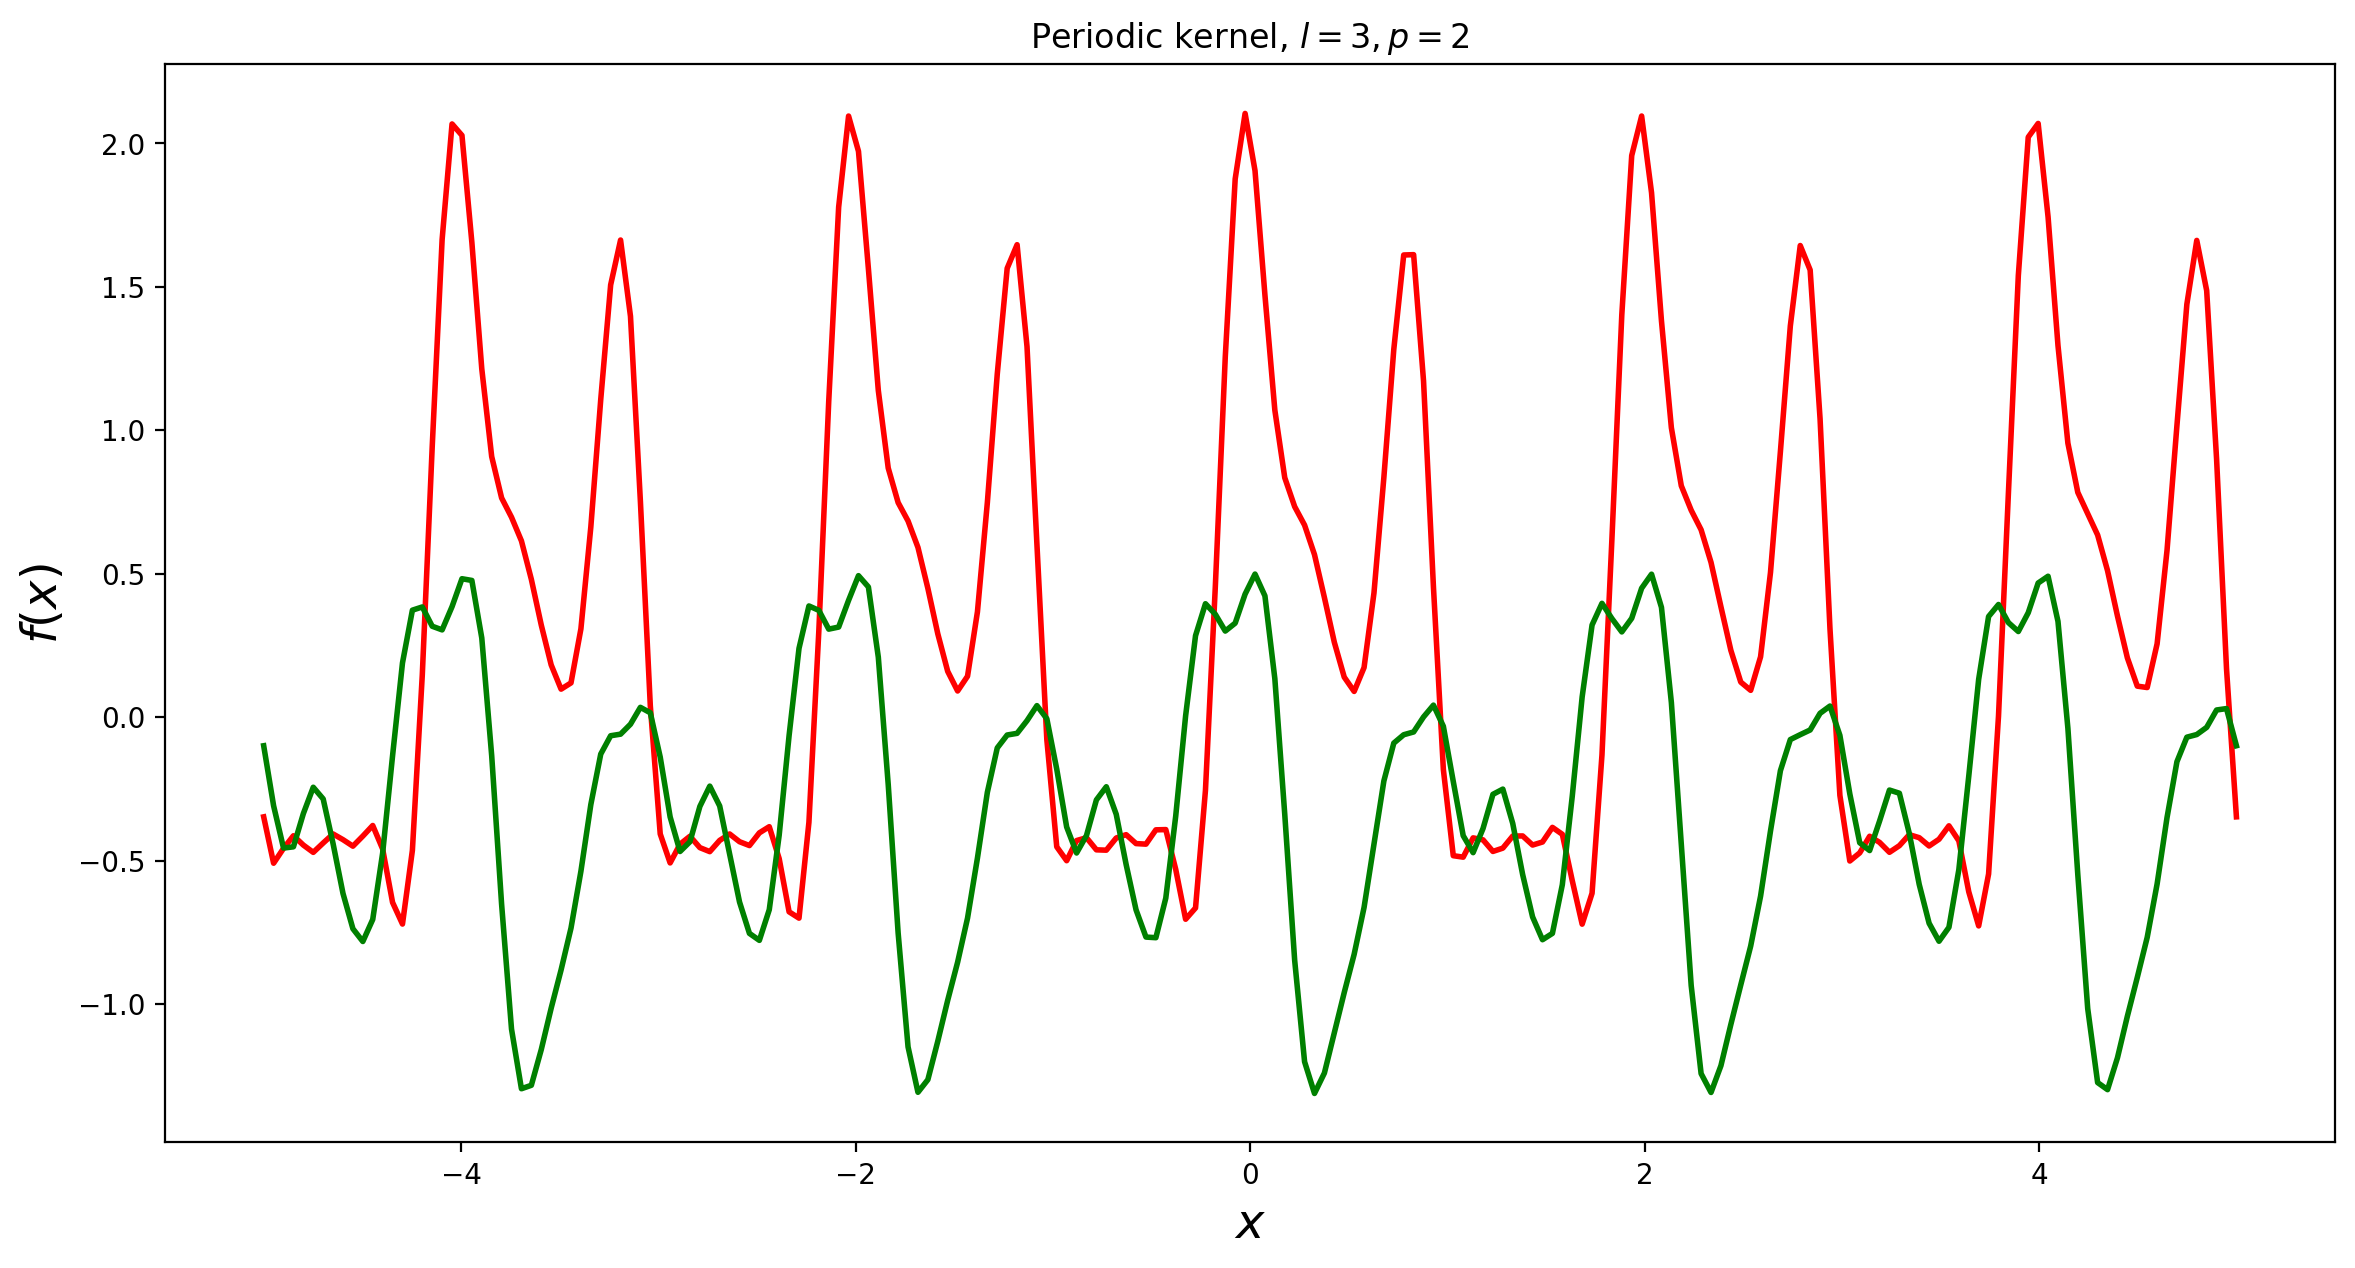

In [16]:
f = sample_gp(X, kernel=periodic_kernel, n_samples=2, l=0.5, p=2)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Periodic kernel, $l=3, p=2$')

Samples from a Gaussian process with Matérn covariance.

- with $\nu = 0.5$ Matérn covariance is equivalent to the so-called *absolute exponential covariance function*.

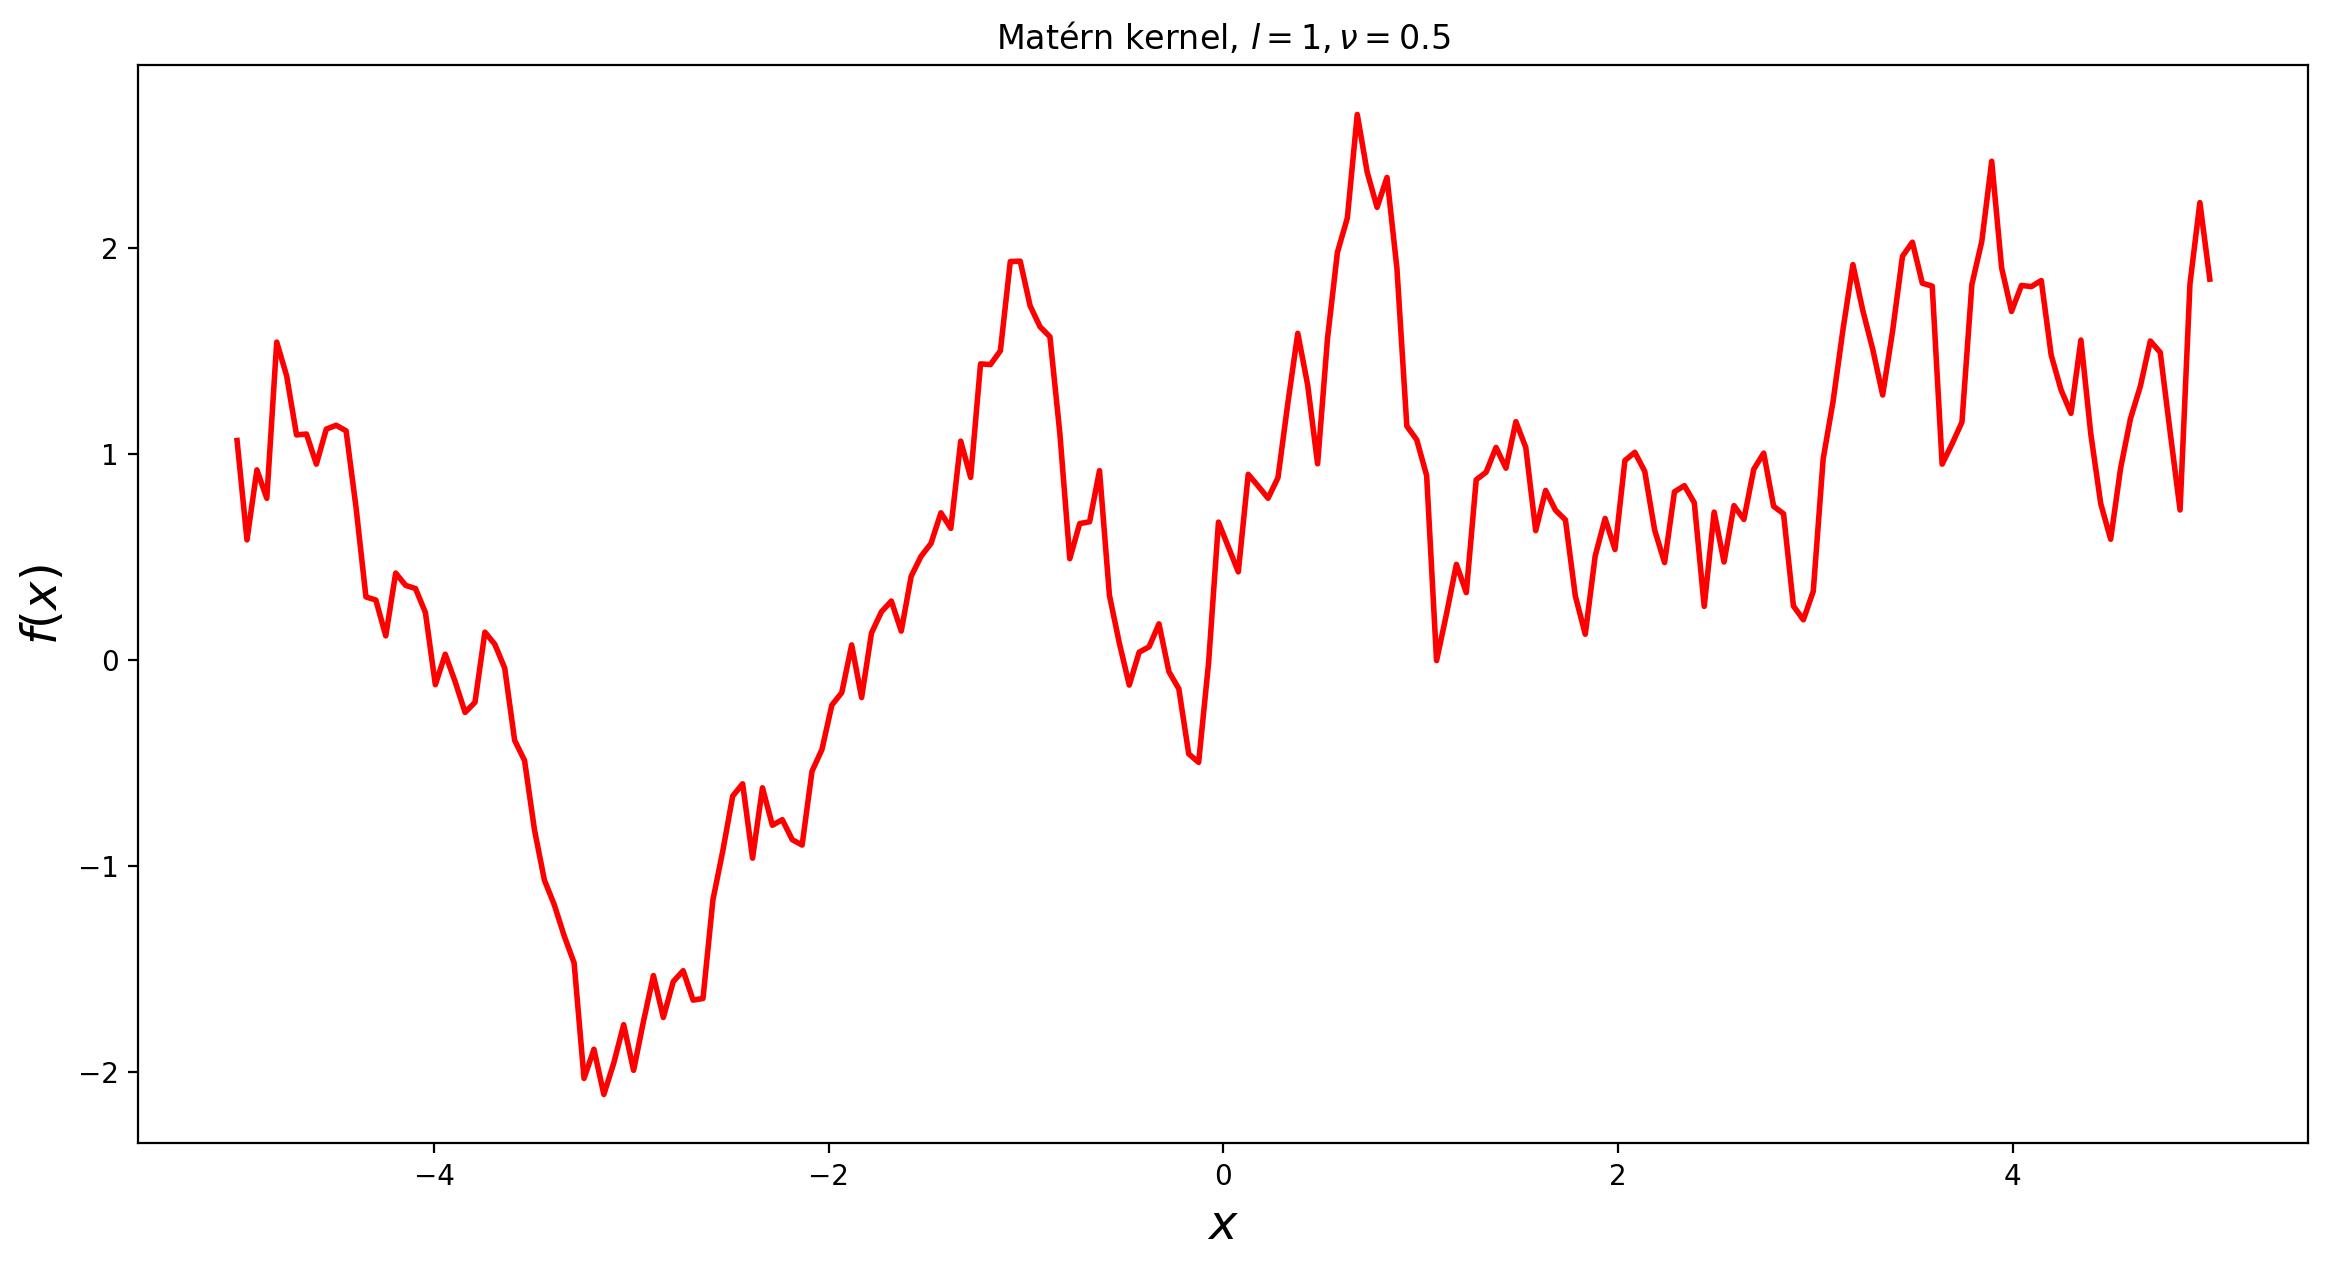

In [17]:
f = sample_gp(X, kernel=matern_kernel, n_samples=1, l=1, nu=0.5)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Matérn kernel, $l=1, \nu=0.5$')

- with $\nu = 1.5$ samples from the Gaussian process (with Matérn covariance) are once differentiable.

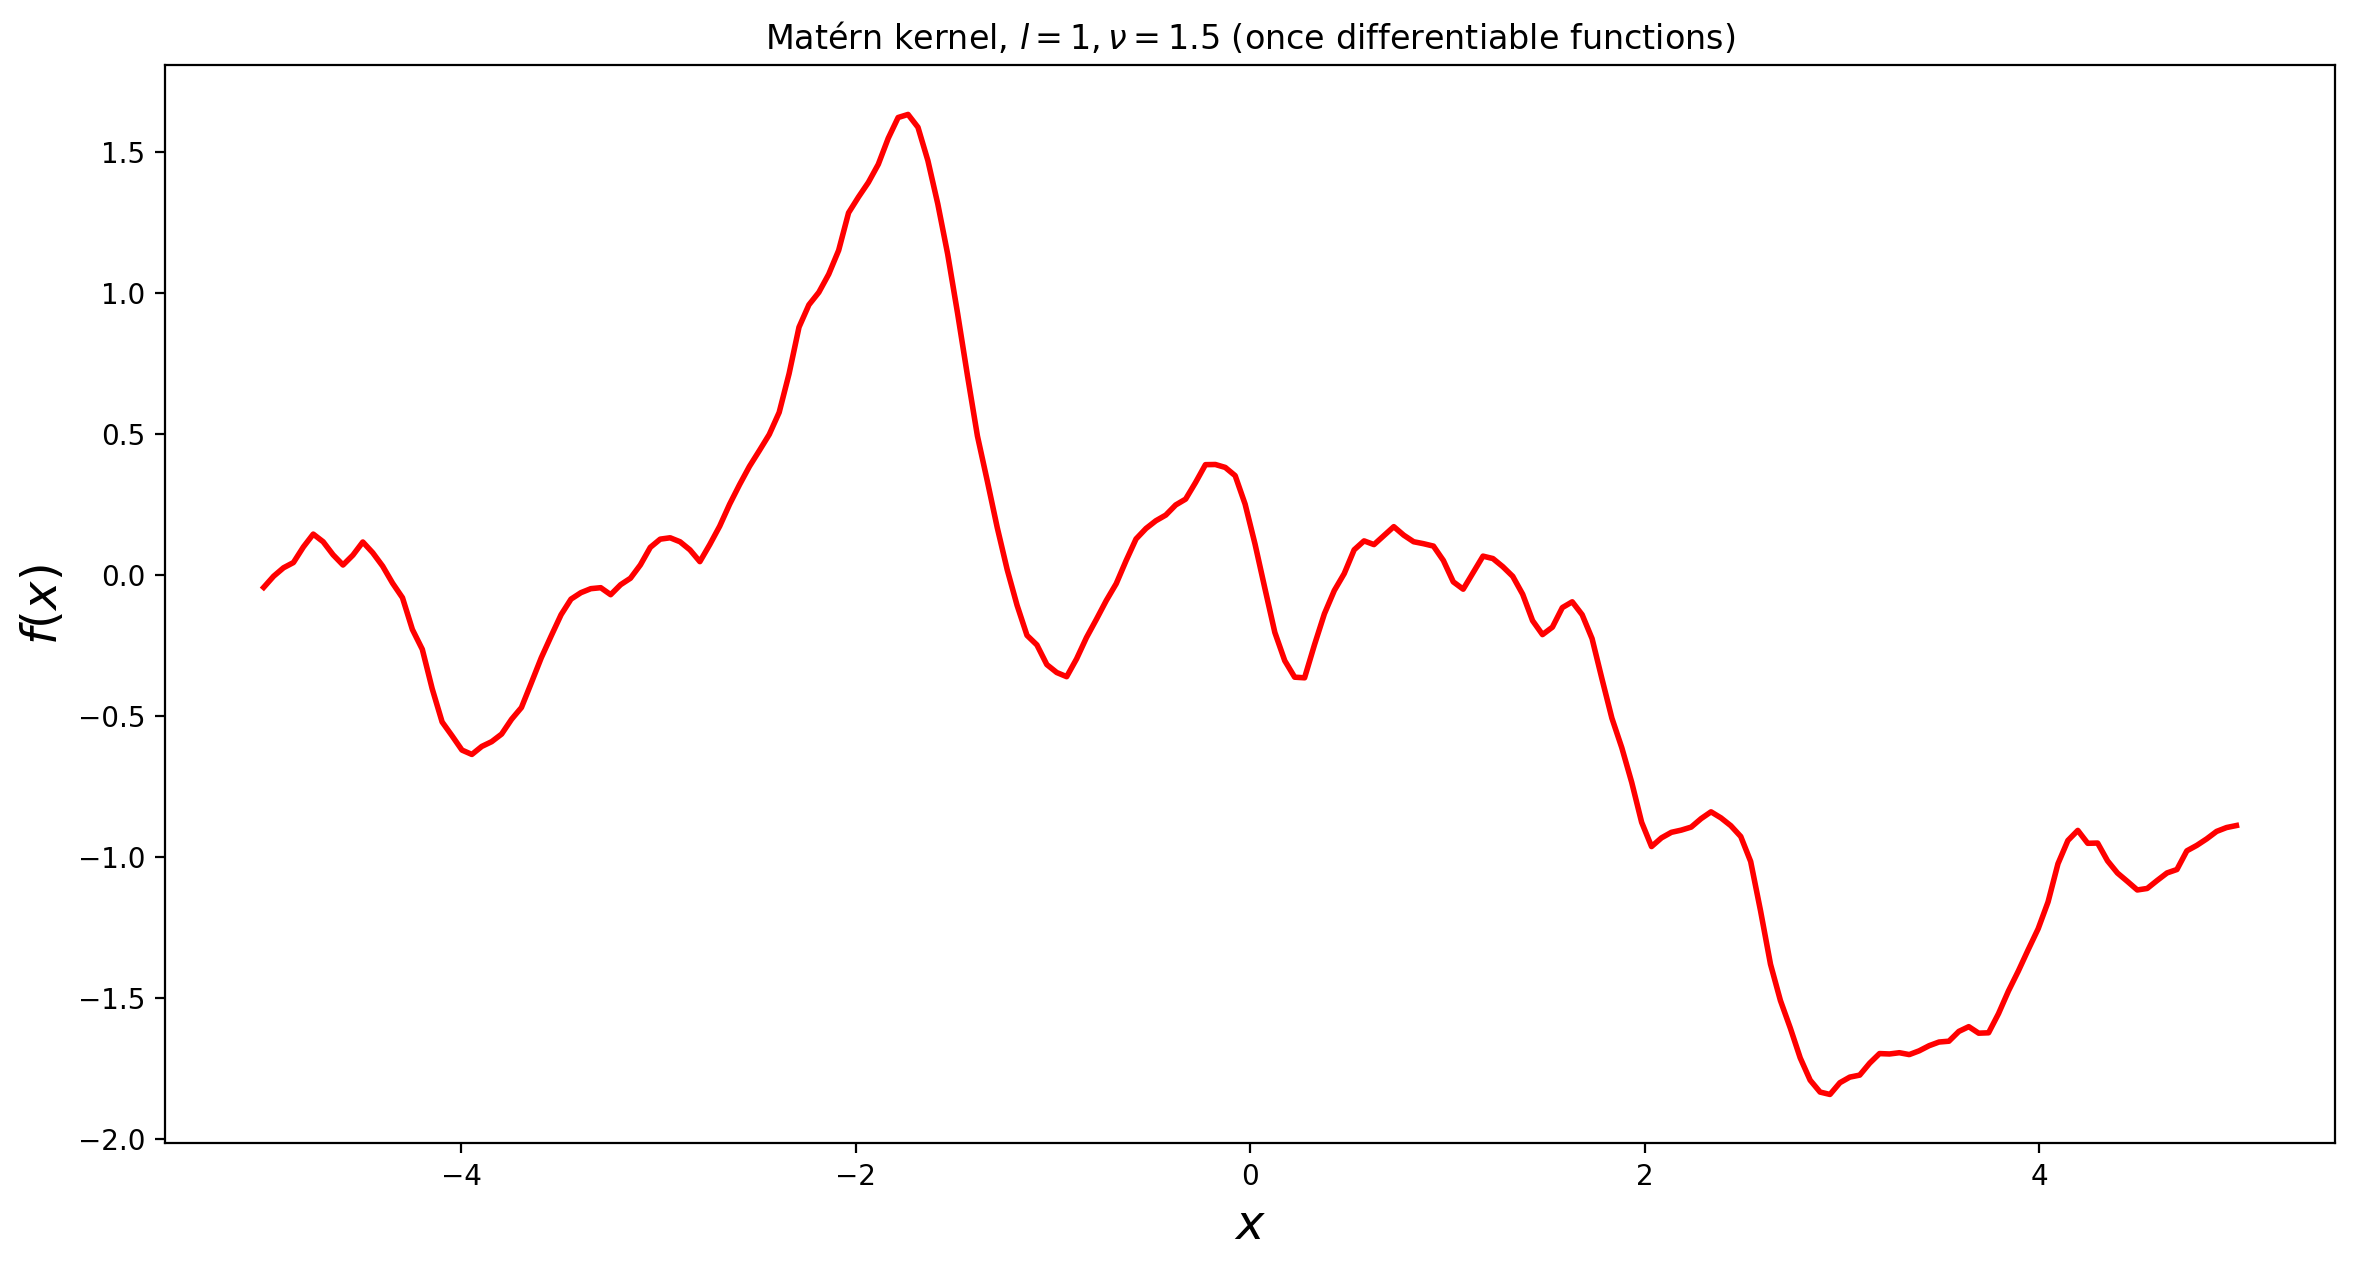

In [18]:
f = sample_gp(X, kernel=matern_kernel, n_samples=1, l=1, nu=1.5)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Matérn kernel, $l=1, \nu=1.5$ (once differentiable functions)')

- with $\nu = 2.5$ samples from the Gaussian process (with Matérn covariance) are twice differentiable.

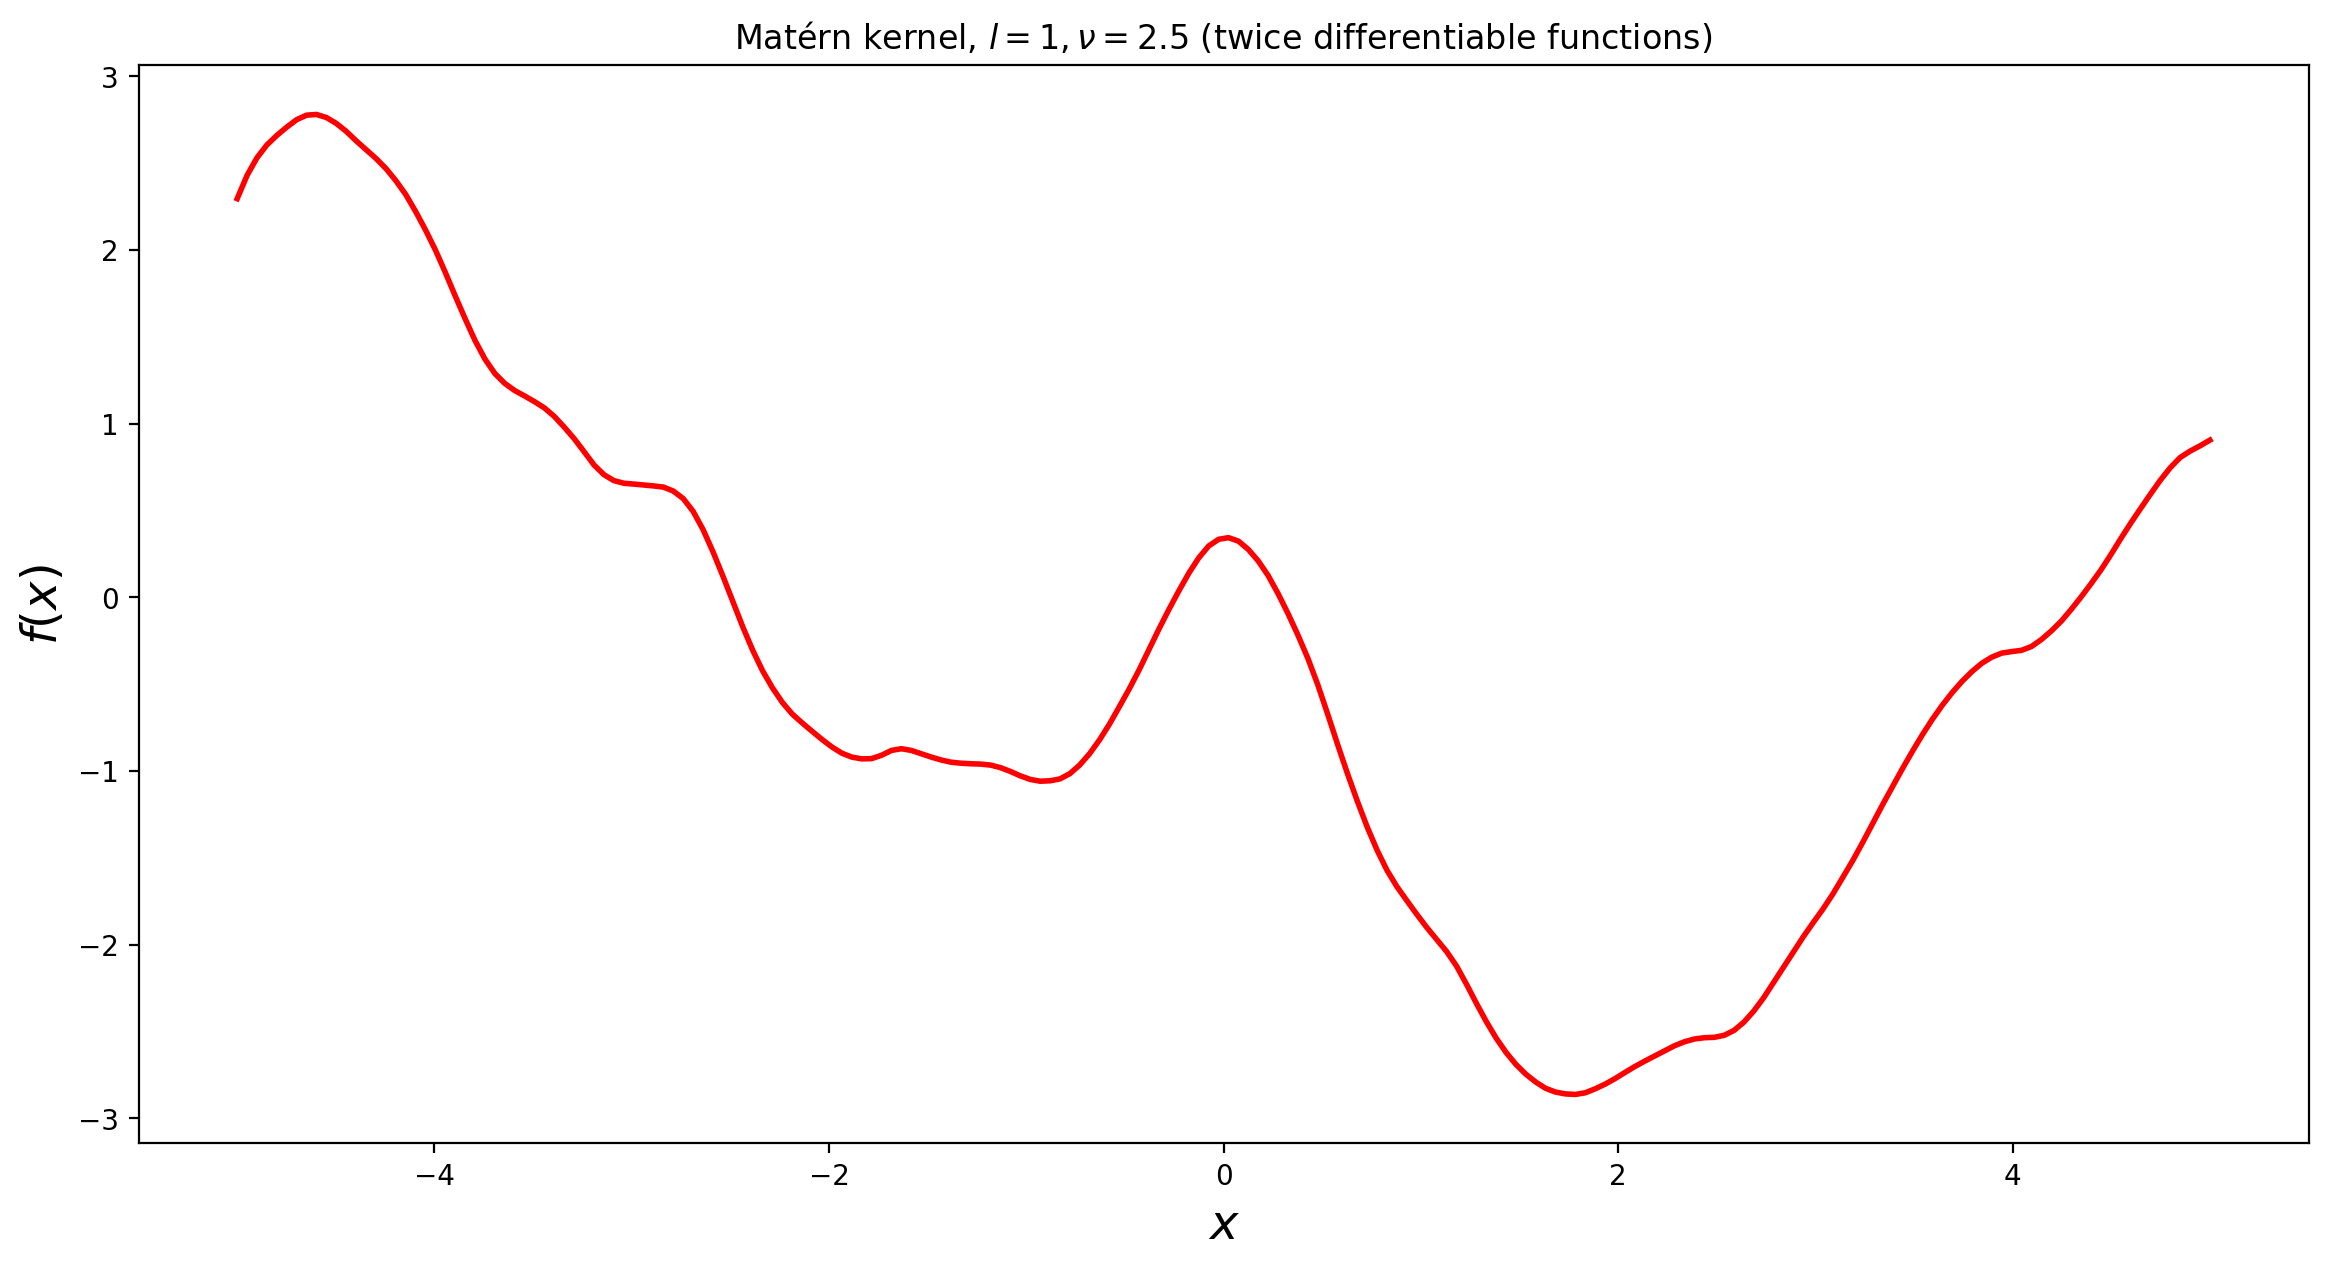

In [19]:
f = sample_gp(X, kernel=matern_kernel, n_samples=1, l=1, nu=2.5)

fig = plt.figure(figsize=(14, 7))
plot_gp_samples(plt.gca(), X, f, r'Matérn kernel, $l=1, \nu=2.5$ (twice differentiable functions)')

- when $\nu \to \infty $ Matérn covariance converges to the Gaussian covariance.

## Gaussian Process Regression

Now, lets assume we have a set of noisy evaluations of some unknown function $f$:

$$\large
\begin{aligned}
  \mathbf{y} & = f\left(\mathbf{X}\right) + \boldsymbol\epsilon \\
  \boldsymbol\epsilon & \sim N \left(\mathbf{0}, \sigma^2\mathbf{I}\right)
\end{aligned}$$

where $\mathbf{X} = \left\{\mathbf{x}_1, \mathbf{x}_2, \mathbf{x}_1, \ldots, \mathbf{x}_n\right\}$.

Our goal is to approximate $f$ using a Gaussian process. That is, we want to learn a posterior distribution over functions that approximate $f$.

Implement `gp_regression` function which takes as an input:

- An array `V` of point coordinates, with shape: $m \times d$.<br>
  These are the points at which we want to evaluate expected value of $f$.
- An array `U` of point coordinates, with shape: $n \times d$.<br>
  These are the points at which we know noisy evaluations of $f$.
- An array `y` of real values, with shape: $n \times 1$.<br>
  These are the noisy observations of $f(\mathbf{U})$.
- Assumed noise level: `sigma` (standard deviation of `y`).
- A covariance function: `kernel`.
- Additional arguments for the covariance function: `kernel_args`.

and returns parameters of the posterior distribution over $f(\mathbf{V})$, i.e.:
- mean $\boldsymbol\mu_\mathbf{V}$ with shape $m \times 1$,
- covariance $\mathbf{\Sigma}_\mathbf{V}$ with shape $m \times m$.

In [20]:
def gp_regression(V, U, y, sigma, kernel=gaussian_kernel, **kernel_args):
    
    K_uu = kernel(U, U, **kernel_args)
    K_uv = kernel(U, V, **kernel_args)
    K_vu = kernel(V, U, **kernel_args)
    K_vv = kernel(V, V, **kernel_args)
    
    I = np.diag(np.diag(np.ones_like(K_uu)))

    M = inv(K_uu + sigma**2 * I)
    
    mu_v = K_vu @ M @ y
    Sigma_v = K_vv - K_vu @ M @ K_uv
    
    return mu_v, Sigma_v

Let's prepare some noisy obsewrvations of $f(\mathbf{U})$:

In [21]:
U   = np.array([-1.5, 0.4, 0.9, 2.0, 3.5]).reshape(-1, 1)  # points where we sample f
F_U = np.array([2.0,  0.1, 0.4, 1.8, 0.5]).reshape(-1, 1)  # true (unobserved) values of f

sigma = 0.25 # measurement noise -> If set to 0.0, we end up with an interpolation. Try it!

y = mvn.rvs(mean=np.squeeze(F_U), cov=sigma).reshape(-1, 1)  # noisy measurements of f(U)

We will approximate $f$ at `N` points spaced equally between `xmin` and `xmax`:

In [22]:
N = 200
xmin, xmax = -6.0, 6.0

V = np.linspace(xmin, xmax, N).reshape(-1, 1)   # points where we want to estimate f

We can now use Gaussian Process Regression to caculate posterior distribution over $f(\mathbf{V})$.

We will plot the expected value of $f(\mathbf{V})$ and its two standard deviations band. We will also plot (unobserved) true values of $f(\mathbf{U})$ and noisy observations $\mathbf{y}$.

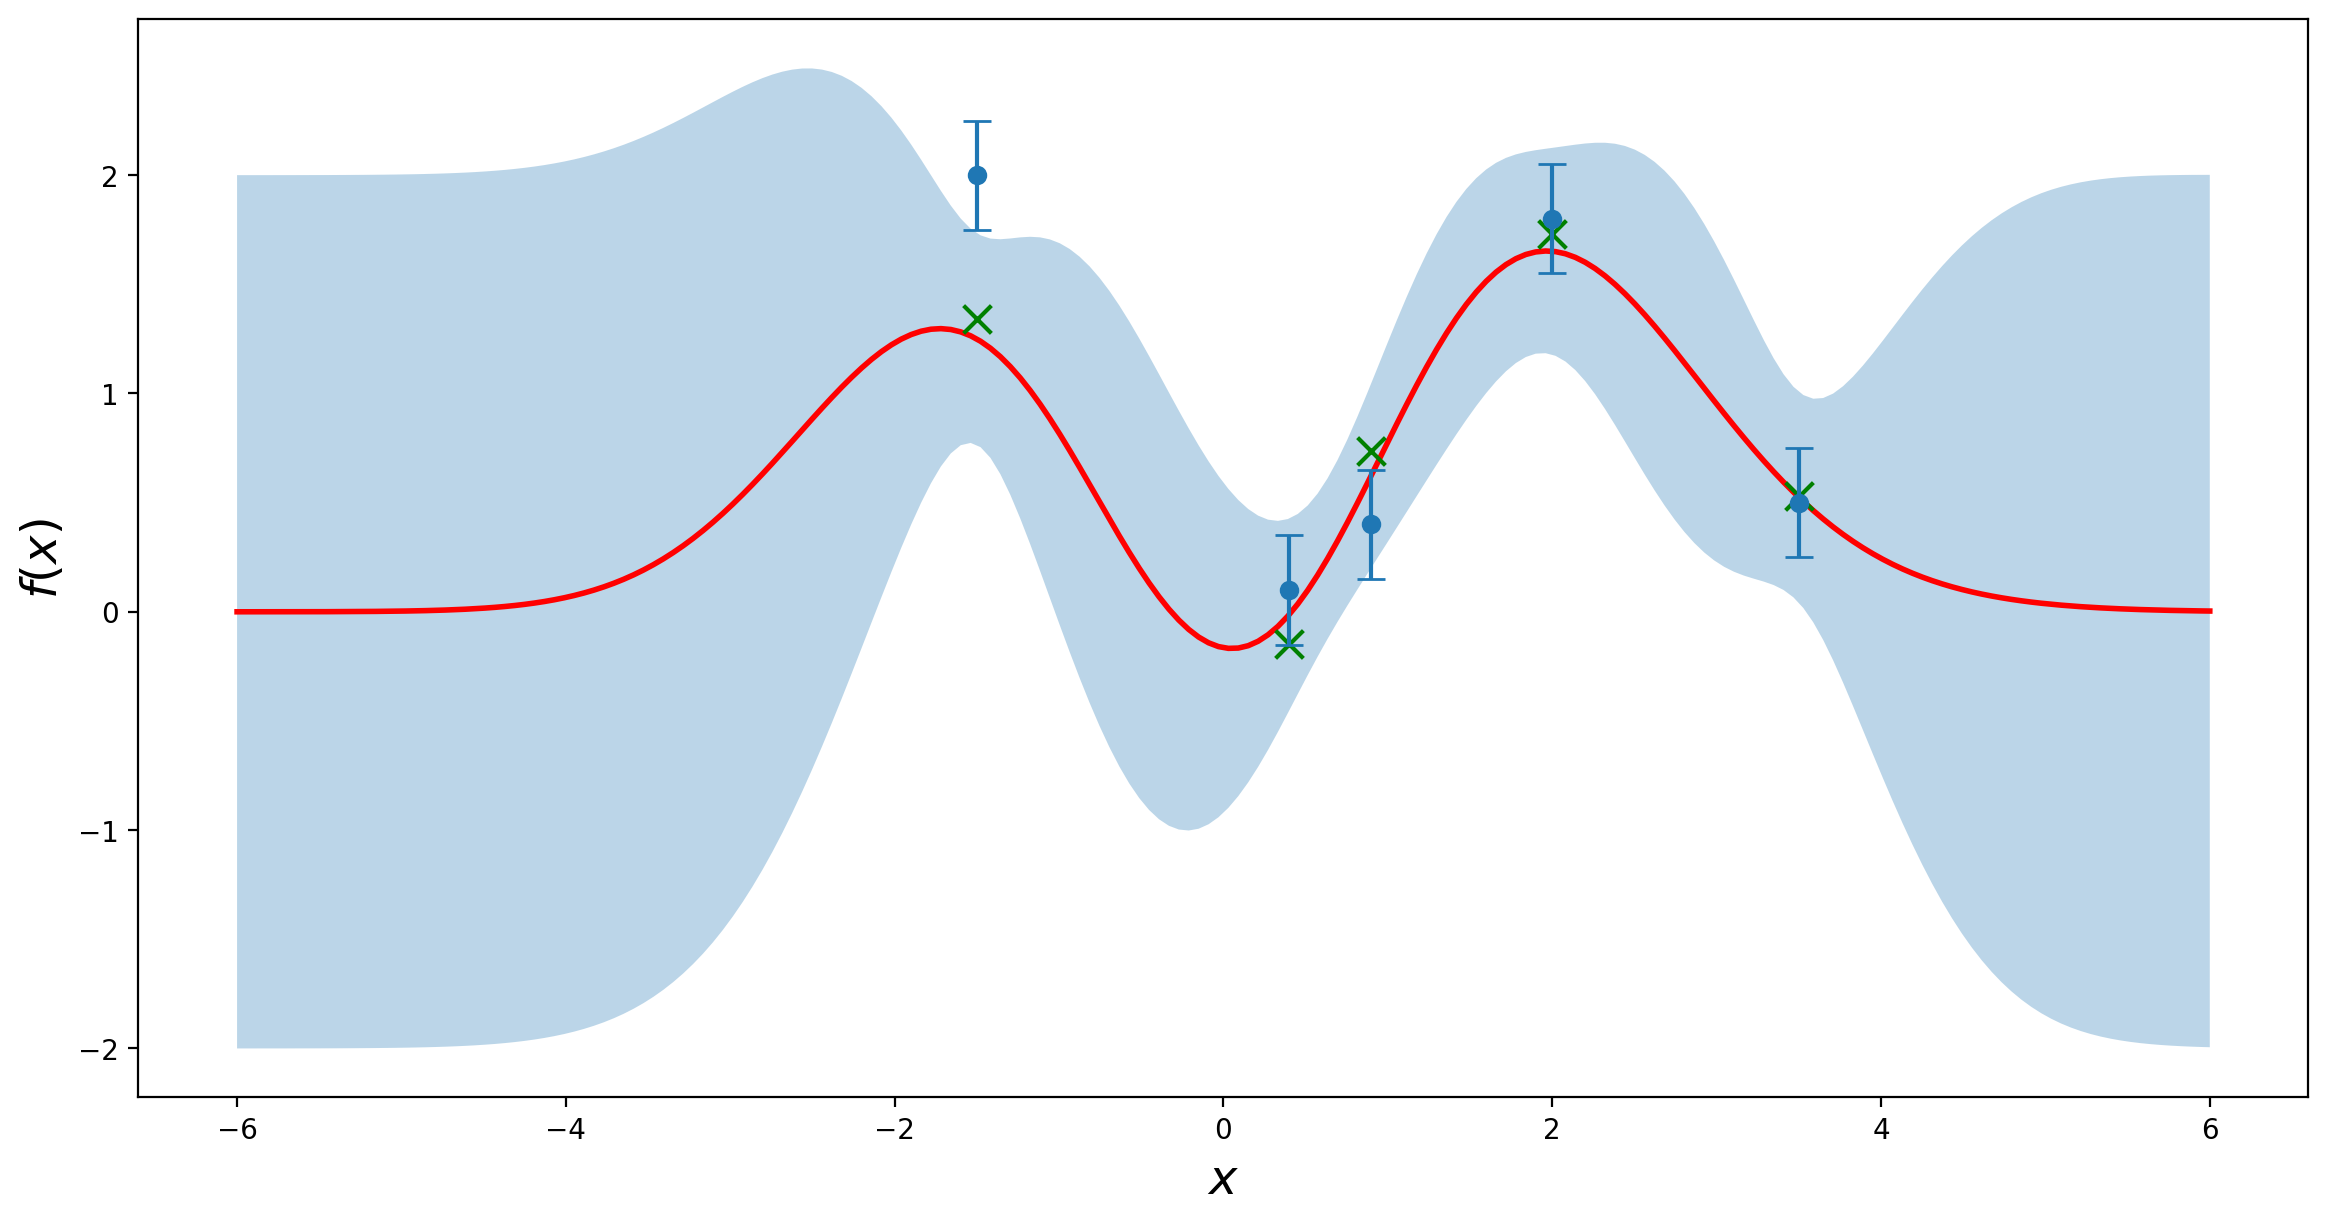

In [23]:
mu_V, Sigma_V = gp_regression(V, U, y, sigma, kernel=gaussian_kernel, l=1.)     # Gaussian process regression

# === Visualizations ===
fig, axes = plt.subplots(figsize=(14, 7))
plot_gpr(axes, V, mu_V, Sigma_V, U, F_U, y, sigma)

# Uncoment to plot sample functions from the posterior
# for i in range(5):
#     plot_gp_samples(axes, V, sample_gp_posterior(np.squeeze(mu_V), Sigma_V), color='c', alpha=0.3)

#### Plot explanation
* *Blue dots* - true, unobserved values of f, with errorbars representing one sigma
* *Green crosses* - measured, noisy values of f
* *Red line* - regression mean at points from V
* *Blue area* - regression std at points from V
  
#### Playground

Feel free to experiment with different kernels, their parameters, number of samples, noise level, etc. Try to find the best kernel for the given data.

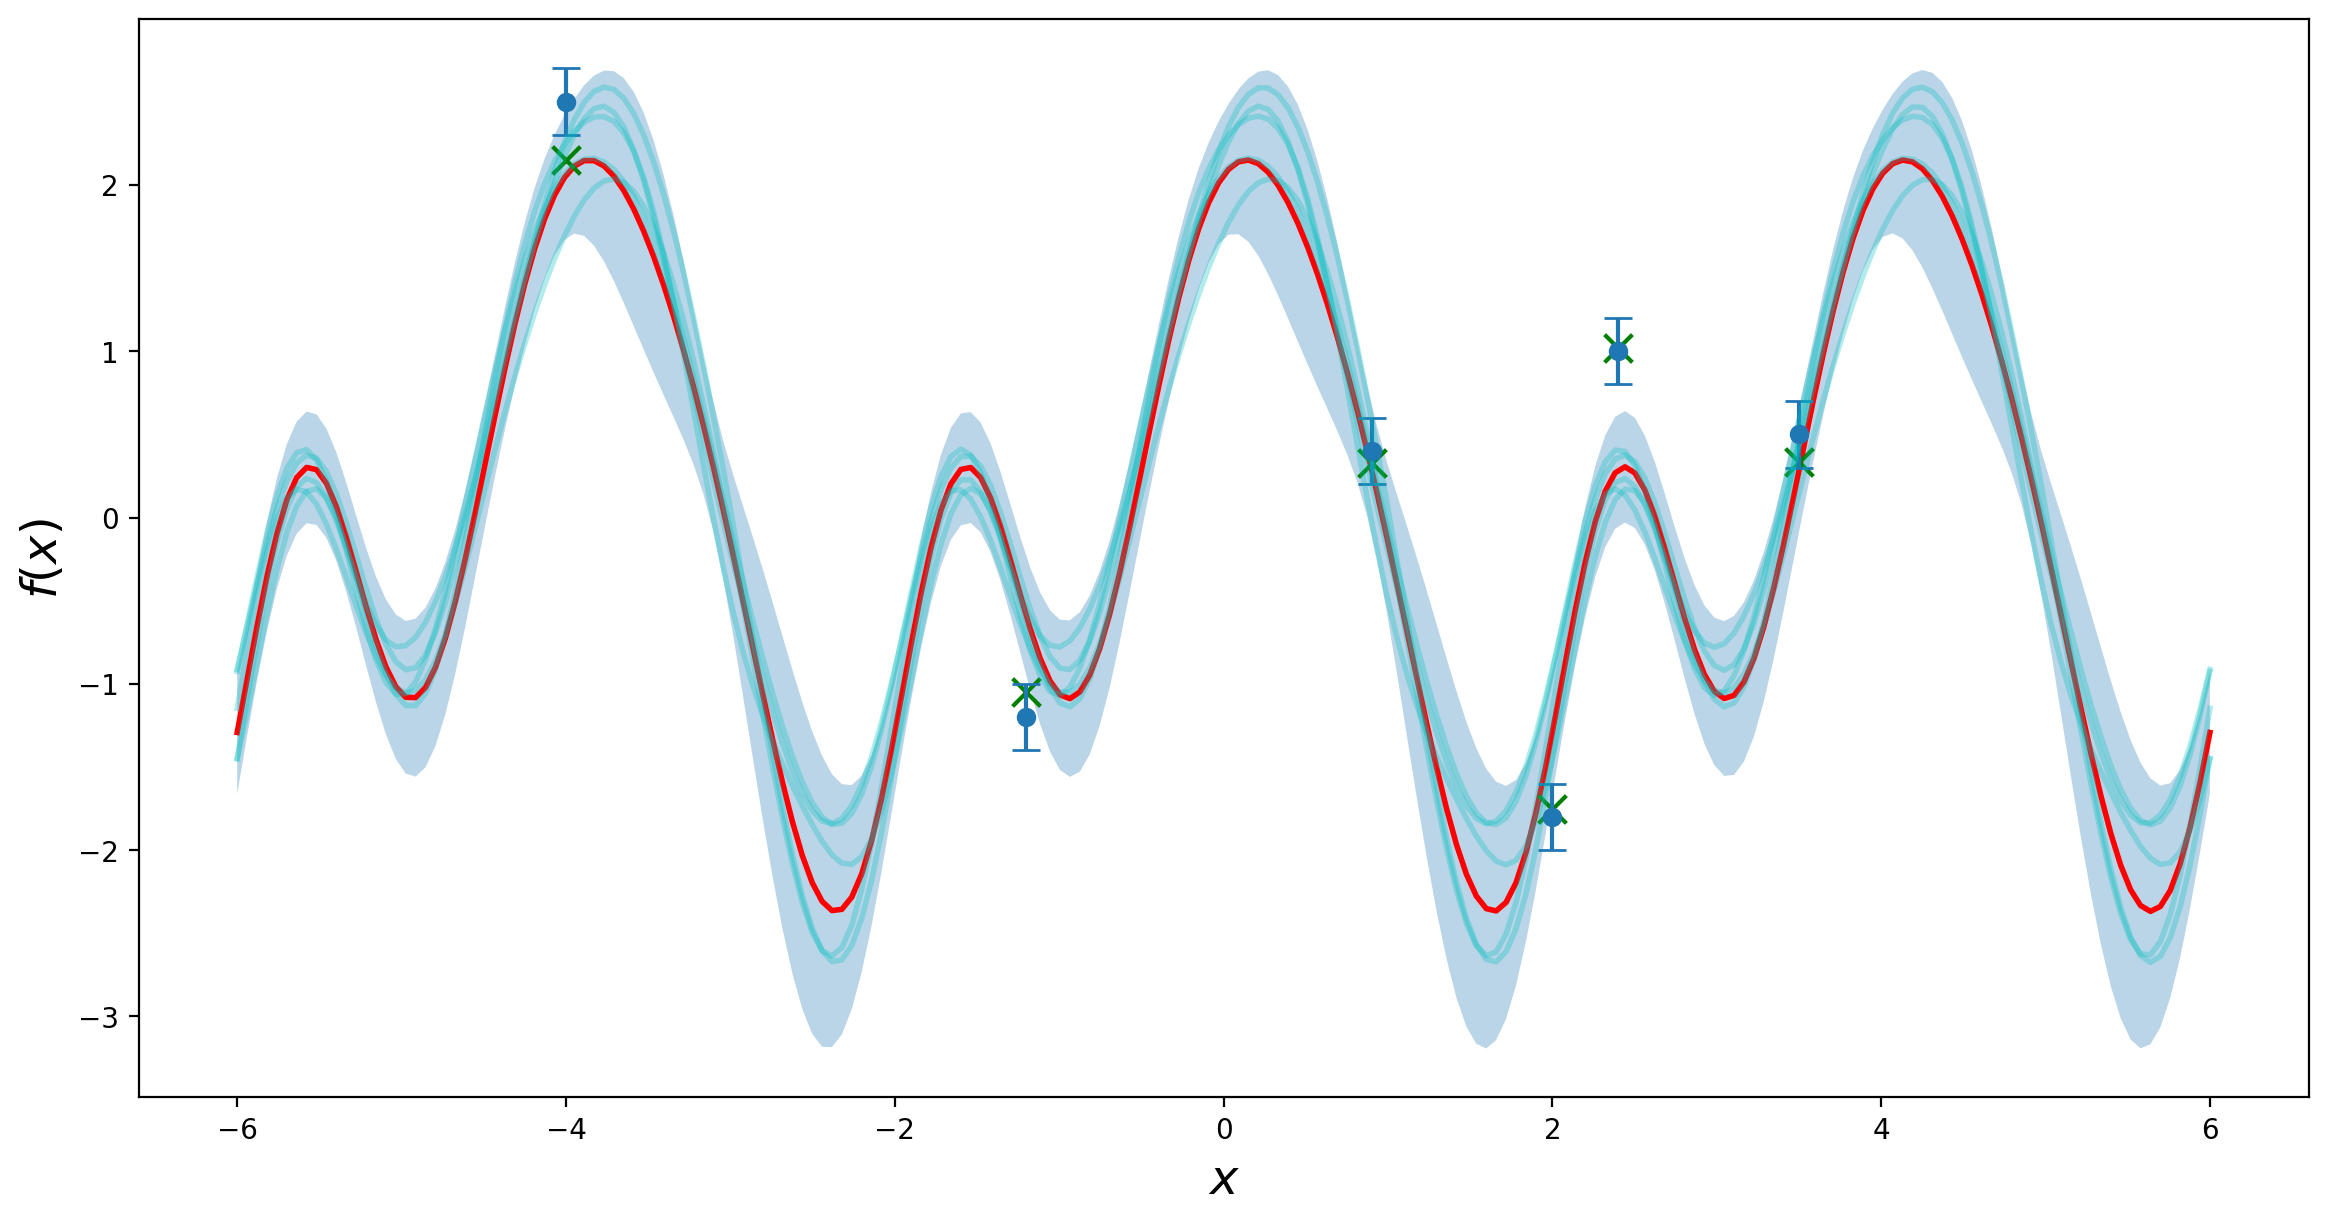

In [24]:
U   = np.array([-4, -1.2, 0.9, 2.0, 2.4, 3.5]).reshape(-1, 1)  # points where we sample f
F_U = np.array([2.5,  -1.2, 0.4, -1.8, 1.0, 0.5]).reshape(-1, 1)  # true (unobserved) values of f

sigma = 0.2 # measurement noise -> If set to 0.0, we end up with an interpolation. Try it!
y = mvn.rvs(mean=np.squeeze(F_U), cov=sigma).reshape(-1, 1)  # noisy measurements of f(U)

V = np.linspace(-6, 6, 200).reshape(-1, 1)  # points where we want to estimate f

mu_V, Sigma_V = gp_regression(V, U, y, sigma, kernel=periodic_kernel, l=1., p=4.) # Gaussian process regression

# === Visualizations ===
fig, axes = plt.subplots(figsize=(14, 7))
plot_gpr(axes, V, mu_V, Sigma_V, U, F_U, y, sigma)

# Uncoment to plot sample functions from the posterior
for i in range(5):
    plot_gp_samples(axes, V, sample_gp_posterior(np.squeeze(mu_V), Sigma_V), color='c', alpha=0.3)

## What is there left for us?

Ok, it was easy, we just put sume kernel with appropiate parameters to the `gp_regression()` function and we found the aproximation of the hidden function $f$. But what if we want to find the **best** kernel for our data? What if our dat is more complex than just a few 1D points?

The answer is to take a capable kernel - presumably the composition of some basic kernels - and use any global optimisation technique to find the best parameters for the kernel. The "goodness" of these parameters will be measured by the metrict used to evaluate our prediction. The most common metrices is the mean squared error (MSE), R2 score, but there are many others.